In [1]:
import numpy as np
from scipy import integrate
from astro import constants as c
from matplotlib import pyplot as plt

In [2]:
def voigt(u,a):
    I = integrate.quad(lambda y: np.exp(-y**2)/(a**2 + (u - y)**2),-np.inf, np.inf)[0]

    return (a/np.pi)*I

In [3]:
def voigt_COLT(x,a):
     #--- coefficients for the rational function (Table A1, Smith+15) ---
    A0 = 15.75328153963877e0
    A1 = 286.9341762324778e0
    A2 = 19.05706700907019e0
    A3 = 28.22644017233441e0
    A4 = 9.526399802414186e0
    A5 = 35.29217026286130e0
    A6 = 0.8681020834678775e0
    B0 = 0.0003300469163682737e0
    B1 = 0.5403095364583999e0
    B2 = 2.676724102580895e0
    B3 = 12.82026082606220e0
    B4 = 3.21166435627278e0
    B5 = 32.032981933420e0
    B6 = 9.0328158696e0
    B7 = 23.7489999060e0
    B8 = 1.82106170570e0
    #------------------------------
    z = x*x
    if(z <= 3.0e0):
       colt_approx = np.exp(-z) * (1.0e0-a*(A0+A1/(z-A2+A3/(z-A4+A5/(z-A6)))))
    else:
       if(z < 25.0e0):
          colt_approx = np.exp(-z) + a * (B0+B1/(z-B2+B3/(z+B4+B5/(z-B6+B7/(z-B8)))))
       else:
          colt_approx = a/np.sqrt(np.pi)/(z-1.5e0-1.5e0/(z-3.5e0-5.0e0/(z-5.5e0)))

    return colt_approx

In [4]:
def sigma_mine(l,T):
    l0 = 1260.42*c.A_to_cm
    A = 2.57e9
    f = 1.22
    m = 28.0855*c.u_cgs
    l = l*c.A_to_cm

    vth = np.sqrt(2*c.kb_cgs*T/m)
    a = A/4/np.pi*l0/vth
    x = c.c_cgs/vth * (l0/l - 1)

    return np.sqrt(np.pi)*c.e_esu**2*f/c.me_cgs/c.c_cgs * l0 / vth * voigt(x,a)

In [5]:
def sigma_colt(l,T):
    lambda13_cm = 1260.42*1e-8
    nu13 = c.c_cgs/lambda13_cm
    nu_cell = c.c_cgs/(l*1e-8)
    A31 = 2.57e9
    m = 28.0855*c.u_cgs
    f13 = 1.22
    e_ch = 4.80320451e-10
    me = 9.10938356e-28
    sigma13_factor = np.sqrt(np.pi)*e_ch**2*f13/me/c.c_cgs
    vth = np.sqrt(2*c.kb_cgs*T/m)
    
    delta_nu_doppler = vth / lambda13_cm
    a = A31 / (4*np.pi * delta_nu_doppler)
    x_cell = (nu_cell - nu13) / delta_nu_doppler
    h_cell = voigt_COLT(x_cell,a)
    sigma = sigma13_factor / delta_nu_doppler * h_cell
    return sigma

In [6]:
def sigma(l,T,line):
    if(line=='OI1302'):
        l0 = 1302.168*c.A_to_cm
        A = 3.41e8
        f = 5.2e-2
        m = 15.999*c.u_cgs
    elif(line=='OI1039'):
        l0 = 1039.23*c.A_to_cm
        A = 9.43e7
        f = 9.16e-3
        m = 15.999*c.u_cgs
    elif(line=='SiII1260'):
        l0 = 1260.42*c.A_to_cm
        A = 2.57e9
        f = 1.22
        m = 28.0855*c.u_cgs
    elif(line=='lya'):
        l0 = 1215.67*c.A_to_cm
        A = 6.265e8
        f = 0.416
        m = c.mp_cgs
    else:
        print('line not implemented yet, try again')

    l = l*c.A_to_cm

    vth = np.sqrt(2*c.kb_cgs*T/m)
    a = A/4/np.pi*l0/vth
    x = c.c_cgs/vth * (l0/l - 1)
    #print('Voigt',Voigt(x,a), 'x',x,'a',a)

    return np.sqrt(np.pi)*c.e_esu**2*f/c.me_cgs/c.c_cgs * l0 / vth * voigt_COLT(x,a)

In [9]:
def sigma_turb(l,T,vturb,line):   #vturb in km/s
    if(line=='OI1302'):
        l0 = 1302.168*c.A_to_cm
        A = 3.41e8
        f = 5.2e-2
        m = 15.999*c.u_cgs
    elif(line=='OI1039'):
        l0 = 1039.23*c.A_to_cm
        A = 9.43e7
        f = 9.16e-3
        m = 15.999*c.u_cgs
    elif(line=='SiII1260'):
        l0 = 1260.42*c.A_to_cm
        A = 2.57e9
        f = 1.22
        m = 28.0855*c.u_cgs
    elif(line=='lya'):
        l0 = 1215.67*c.A_to_cm
        A = 6.265e8
        f = 0.416
        m = c.mp_cgs
    else:
        print('line not implemented yet, try again')

    l = l*c.A_to_cm

    vth = np.sqrt(2*c.kb_cgs*T/m + (1e5*vturb)**2)
    a = A/4/np.pi*l0/vth
    x = c.c_cgs/vth * (l0/l - 1)
    #print('Voigt',Voigt(x,a), 'x',x,'a',a)

    return np.sqrt(np.pi)*c.e_esu**2*f/c.me_cgs/c.c_cgs * l0 / vth * voigt_COLT(x,a)

In [12]:
line = 1260.42
sigma = np.vectorize(sigma)
sigma_turb = np.vectorize(sigma_turb)
#sigma_mine = np.vectorize(sigma_mine)
l = np.linspace(line-2,line+2,16000)

In [65]:
sigma_fid = sigma_turb(l,1.5e2,0,'SiII1260')
sigma_check = sigma(l,1.5e2,'SiII1260')
sigma_vturb10 = sigma_turb(l,1.5e2,10,'SiII1260')
sigma_vturb20 = sigma_turb(l,1.5e2,20,'SiII1260')
sigma_vturb50 = sigma_turb(l,1.5e2,50,'SiII1260')
sigma_vturb100 = sigma_turb(l,1.5e2,100,'SiII1260')

In [15]:
sigma_T3 = sigma(l,1e3,'SiII1260')
sigma_T4 = sigma(l,1e4,'SiII1260')
#sigma_T5 = sigma_colt(l,1e5)
sigma_T2 = sigma(l,1.5e2,'SiII1260')
sigma_T5 = sigma(l,1e5,'SiII1260')
sigma_T1 = sigma(l,1e1,'SiII1260')
#sigma_218 = sigma_colt(l,218)
v = (l-line)/line*c.c_cgs/1e5

1.8612133177542965e-11
8.331503620632992e-12
2.8792358100230377e-12
9.34952611290173e-13


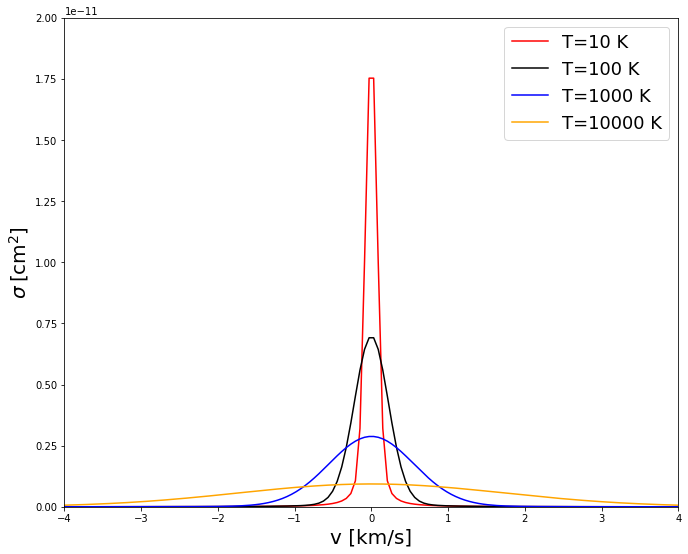

In [9]:
fig, ax = plt.subplots(figsize=(11,9))
# ax.semilogy(v,sigma_T1,'red',label='T=10 K')
# ax.semilogy(v,sigma_T2,'black',label='T=100 K')
# ax.semilogy(v,sigma_T3,'b',label='T=1000 K')
# ax.semilogy(v,sigma_T4,'orange',label='T=10000 K')
ax.plot(v,sigma_T1,'red',label='T=10 K')
ax.plot(v,sigma_T2,'black',label='T=100 K')
ax.plot(v,sigma_T3,'b',label='T=1000 K')
ax.plot(v,sigma_T4,'orange',label='T=10000 K')
#ax.semilogy(v,sigma_T5,'r',label='T=100000 K')
ax.set_xlabel('v [km/s]',fontsize=20)
ax.set_ylabel(r'$\sigma \: [\mathrm{cm}^2]$',fontsize=20)
ax.set_xlim(-4,4)
ax.set_ylim(1e-15,2e-11)
ax.legend(fontsize=18)
print(sigma(1260.42,1e1,'SiII1260'))
print(sigma(1260.42,1e2,'SiII1260'))
print(sigma(1260.42,1e3,'SiII1260'))
print(sigma(1260.42,1e4,'SiII1260'))
# print(np.trapz(sigma_T1,v))
# print(np.trapz(sigma_T2,v))
# print(np.trapz(sigma_T3,v))
# print(np.trapz(sigma_T4,v))

In [22]:
print(l)
print(sigma(l,1.5e2,'SiII1260'))

[1258.42       1258.42025002 1258.42050003 ... 1262.41949997 1262.41974998
 1262.42      ]
[1.47508949e-19 1.47545894e-19 1.47582853e-19 ... 1.48522319e-19
 1.48485243e-19 1.48448180e-19]


In [26]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [42]:
ind = find_nearest(sigma(l,1.5e2,'SiII1260'),np.log(2)/1e12)
print(sigma(l[ind-1:ind+2],1.5e2,'SiII1260'))
print(v[ind-1:ind+2])

[1.03743970e-12 6.36525473e-13 3.84606438e-13]
[0.44599827 0.5054647  0.56493114]


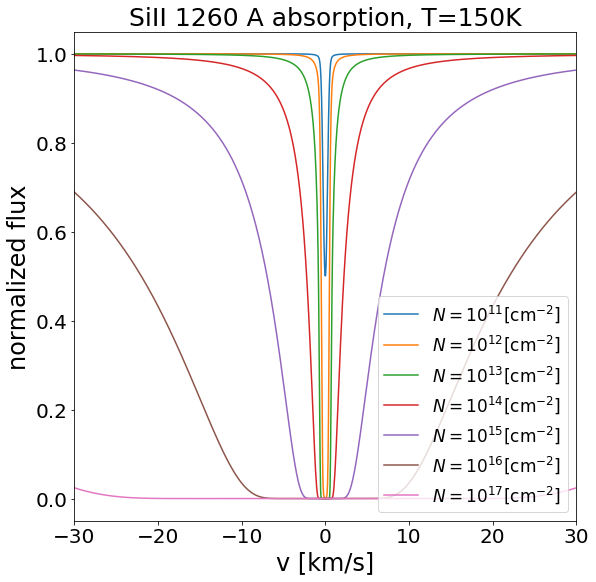

In [43]:
import matplotlib
NN = [12,14,15,16,17]
fig2, ax2 = plt.subplots(figsize=(9,9))
for N in range(11,18,1):
    tau = np.power(10,9)*sigma_T2
    tau = tau*np.power(10,N-9)
    I = np.exp(-tau)
    ax2.plot(v,I,label=r'$N = 10^{%i} [\rm{cm}^{-2}]$'%N)
    ax2.set_title('SiII 1260 A absorption, T=150K',fontsize=25)
    ax2.set_xlabel('v [km/s]',fontsize=24)
    ax2.set_ylabel('normalized flux',fontsize=24)
    ax2.set_xlim(-30,30)
    ax2.legend(fontsize=17,loc='lower right')
    matplotlib.rcParams.update({'font.size': 20})
# fig2.savefig('/Users/mauerhof/Documents/Presentations/2019/Muse_05.19/figures/SiII_absorption_modifiedbymistakethe19092019.pdf')
# fig2.savefig('/Users/mauerhof/Documents/Papers/MyPaper/covering/figures/abs_uniform/SiII_abs.pdf')

4.080943575677682e-12
4.080968544358371e-12
4.080968723642142e-12
4.080968361197433e-12


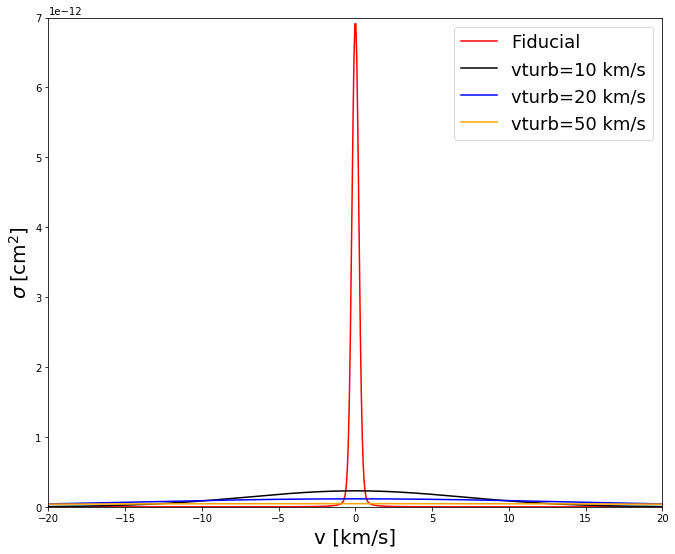

In [32]:
fig, ax = plt.subplots(figsize=(11,9))
# ax.semilogy(v,sigma_fid,'red',label='Fiducial')
# # ax.semilogy(v,sigma_check,'black',label='Check')
# ax.semilogy(v,sigma_vturb10,'b',label='vturb=10 km/s')
# ax.semilogy(v,sigma_vturb20,'orange',label='vturb=20 km/s')
# ax.semilogy(v,sigma_vturb50,'purple',label='vturb=50 km/s')
ax.plot(v,sigma_fid,'red',label='Fiducial')
ax.plot(v,sigma_vturb10,'black',label='vturb=10 km/s')
ax.plot(v,sigma_vturb20,'b',label='vturb=20 km/s')
ax.plot(v,sigma_vturb50,'orange',label='vturb=50 km/s')
ax.set_xlabel('v [km/s]',fontsize=20)
ax.set_ylabel(r'$\sigma \: [\mathrm{cm}^2]$',fontsize=20)
ax.set_xlim(-20,20)
ax.set_ylim(1e-15,7e-12)
ax.legend(fontsize=18)
# print(sigma(1260.42,1e1,'SiII1260'))
# print(sigma(1260.42,1e2,'SiII1260'))
# print(sigma(1260.42,1e3,'SiII1260'))
# print(sigma(1260.42,1e4,'SiII1260'))
print(np.trapz(sigma_fid,v))
print(np.trapz(sigma_vturb10,v))
print(np.trapz(sigma_vturb20,v))
print(np.trapz(sigma_vturb50,v))

In [101]:
import matplotlib
NN = [12,14,15,16,17]
NNN = 13
for N in range(12,18,1):
    fig2, ax2 = plt.subplots(figsize=(9,9))
    tau = np.power(10,N)*sigma_fid
    I = np.exp(-tau)
    EW = np.trapz((1-I),l)
    ax2.plot(l-line,I,label='Fiducial, EW=%.2f'%EW)
    tau = np.power(10,N)*sigma_vturb10
    I = np.exp(-tau)
    EW = np.trapz((1-I),l)
    ax2.plot(l-line,I,label=r'$vturb=10$, EW=%.2f'%EW)
    tau = np.power(10,N)*sigma_vturb20
    I = np.exp(-tau)
    EW = np.trapz((1-I),l)
    ax2.plot(l-line,I,label=r'$vturb=20$, EW=%.2f'%EW)
    tau = np.power(10,N)*sigma_vturb50
    I = np.exp(-tau)
    EW = np.trapz((1-I),l)
    ax2.plot(l-line,I,label=r'$vturb=50$, EW=%.2f'%EW)
    tau = np.power(10,N)*sigma_vturb100
    I = np.exp(-tau)
    EW = np.trapz((1-I),l)
    ax2.plot(l-line,I,label=r'$vturb=100$, EW=%.2f'%EW)
    
    ax2.set_title(r'exp(-$\tau_{1260}(\lambda))$, T=150K, $N = 10^{%i} [\rm{cm}^{-2}]$'%N,fontsize=25)
    ax2.set_xlabel(r'$\lambda - \lambda_0$ [$\AA$]',fontsize=24)
    ax2.set_ylabel('normalized flux',fontsize=24)
    ax2.set_xlim(-1,1.4)
    ax2.legend(fontsize=15,loc='lower right')
#     ax2.annotate(r'$N = 10^{%i} [\rm{cm}^{-2}]$'%N, xy=(-0.9, 0.1), fontsize=22, weight='bold')
    matplotlib.rcParams.update({'font.size': 20})
    fig2.savefig('/Users/mauerhof/Documents/Presentations/2019/Rascas3_27.09.19/vturb_EW_%i.pdf'%N)
    plt.close()
# fig2.savefig('/Users/mauerhof/Documents/Papers/MyPaper/covering/figures/abs_uniform/SiII_abs.pdf')

In [ ]:
# tau = 4.3e10*sigma_T3
# tau = tau*1e10
# I = np.exp(-tau)
# ax2.plot(v,I,label='N = 4,20')
# ax2.set_xlabel('v [km/s]',fontsize=20)
# ax2.set_ylabel('Flux, normalized',fontsize=20)
# ax2.set_xlim(-300,300)
# ax2.legend(fontsize=20)

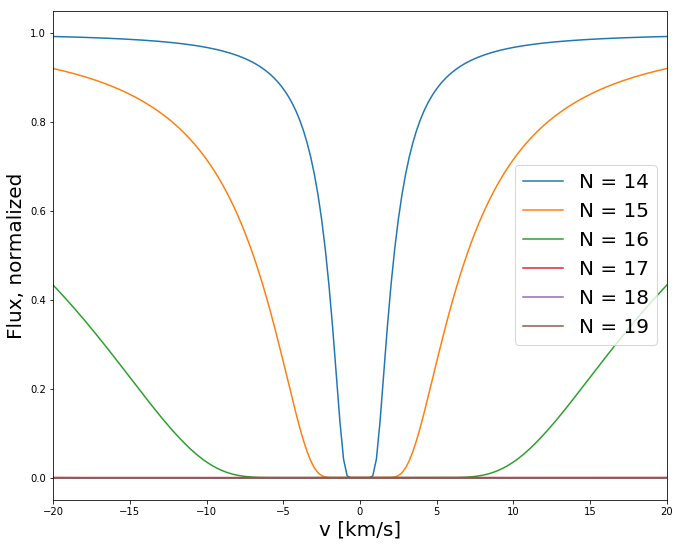

In [12]:
fig3, ax3 = plt.subplots(figsize=(11,9))
for N in range(14,20):
    tau = 10**N*sigma_T2
    I = np.exp(-tau)
    ax3.plot(v,I,label='N = %i'%N)
    ax3.set_xlabel('v [km/s]',fontsize=20)
    ax3.set_ylabel('Flux, normalized',fontsize=20)
    ax3.set_xlim(-20,20)
    ax3.legend(fontsize=20)